# iTunes music library analysis: Data Visualisation

This is the second post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
This notebook covers visualisation and overview of data I prepared in the [previos notebook](). 

In the previous step I parsed iTunes music library xml file to create a sqlite3 database of tracks for the test dataset. I also transformed the csv file with labeled tracks into a sqlite3 database for the training set. Using the Echo Nest API I got track attributes for both sets.

As a result of the above manipulations I have two databases (DBs): 
* train DB contains 91 labeled tracks with one of the three classes: "cycling", "yoga", "ballet";
* test DB contains 331 non-labeled tracks. 

The next step in my analysis is to visualize both datasets and examine track attributes. 

For the summary of this analysis, its goals, methods and installation notes please go to [link](). 
Data gathering and cleaning process are described in detail in the [previos notebook](). As a shortcut, in this notebook I import module "data_cleaning.py" where I perform steps from the previous notebook. 

I use **[Matplotlib](http://matplotlib.org/)** and **[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/)** packages for data visualization. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np
from sqlitedict import SqliteDict

# import my module
import data_cleaning as cln

# set seaborn plot defaults
import seaborn as sns; sns.set(palette="husl")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

In [2]:
#TODO: change name of the db to './labeled_tracks'
# train DB
train_db = SqliteDict('./chosen_tracks', autocommit=True)

# test DB
test_db = SqliteDict('./itunes_tracks',
                     autocommit=True)

## Data overview  
  
I have two DBs with track attributes data from the Echo Nest API. Next step is to read in data from both DBs and take a look at what I'm working with.

I transform DBs into pandas dataframes (DF), which one can think of as an Excel-like table of values. Dataframes have various methods that can be called to easily learn about the data contained in them. I leave in the DF only tracks with  attributes data for further analysis. 

### Training data overview

In [4]:
# create a df with training data
train_df = cln.read_db_in_pandas(train_db)

# rearrange the order of columns 
cols = train_df.columns.tolist()
cols = cols[0:1] + cols[2:4] + cols[1:2] + cols[4:]
train_df = train_df.ix[:, cols]

In [5]:
# list of categories
categories = list(pd.unique(train_df.category.ravel()))

print ("Tracks in the dataset belong " 
       "to {} categories: {}."
       .format(len(categories), ", ".join(categories)))

# count tracks in each category
cat_count = pd.value_counts(train_df.category.ravel())

# print categories
for category in categories:
    print ("{} tracks represent \'{}\' category."
           .format(cat_count[category], category))

Tracks in the dataset belong to 3 categories: cycling, focus, yoga.
26 tracks represent 'cycling' category.
34 tracks represent 'focus' category.
31 tracks represent 'yoga' category.


### Training data visualisation
I plot attributes with pairplot (sns.pairplot) function to examine pairwise relationships in a dataset.  
By default, this function creates a grid of Axes such that each variable in data is shared in the y-axis across a single row and in the x-axis across a single column. The diagonal Axes show the univariate distribution of the data for the variable in that column. Each track class is coloured with a different colour so I can see the behaviour of classes. 

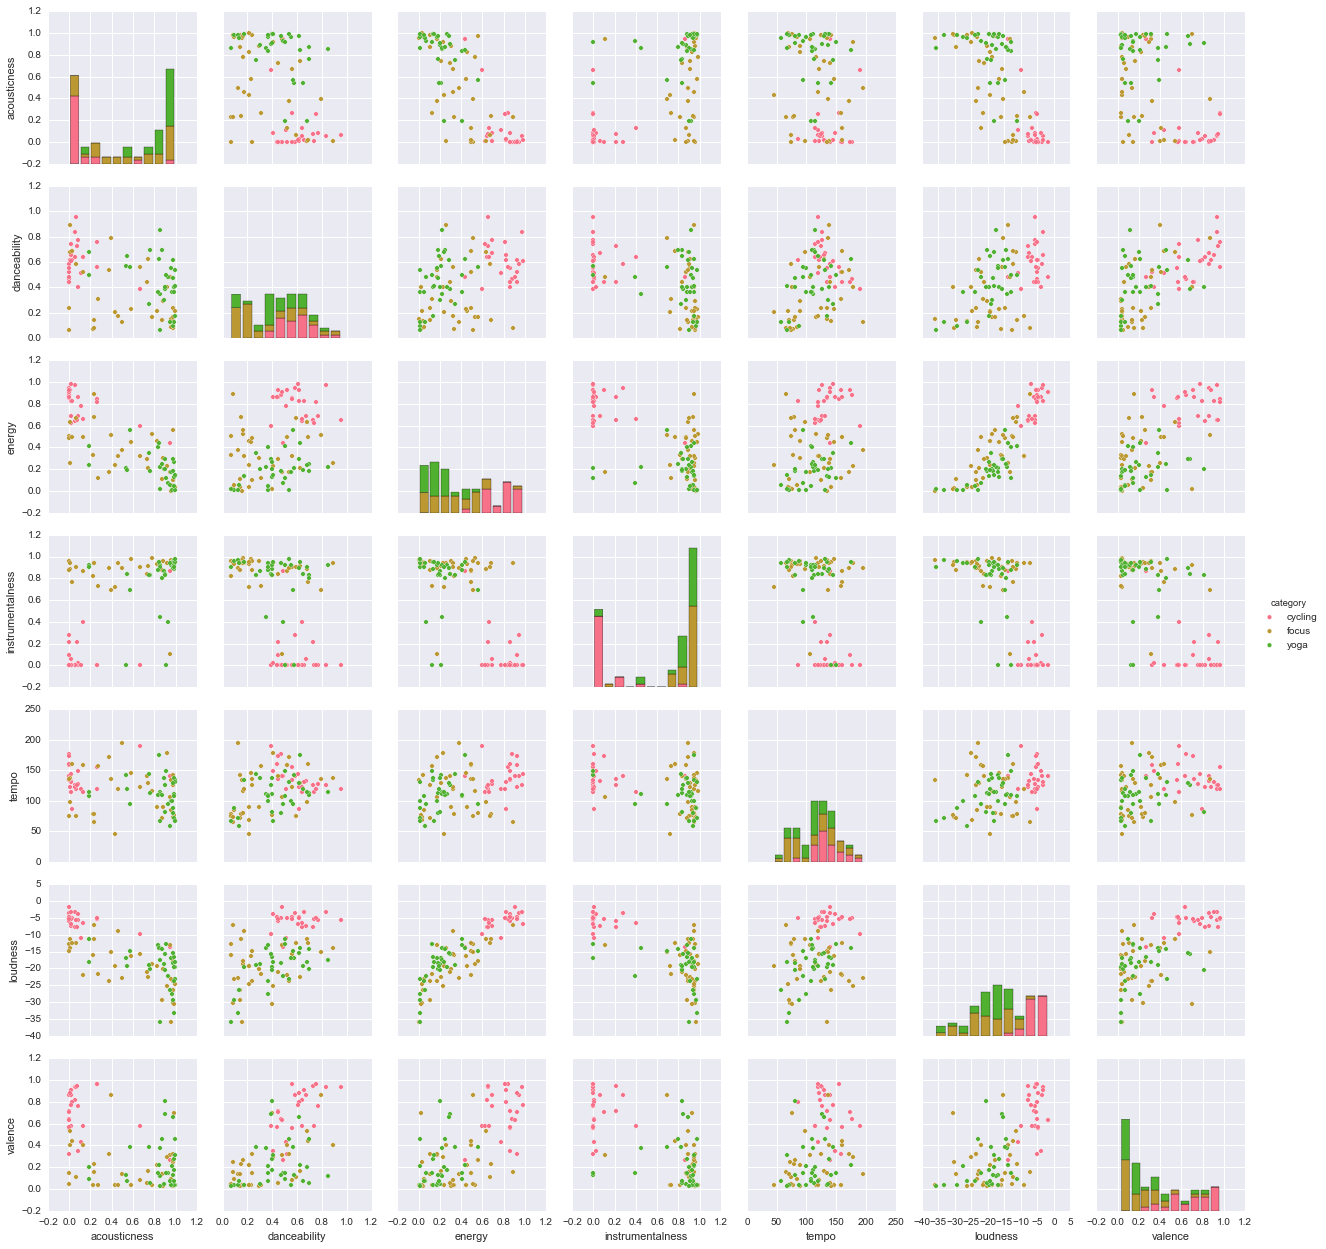

In [6]:
sns.pairplot(train_df, hue="category", 
             vars=['acousticness', 'danceability', 
                   'energy', 'instrumentalness', 
                   'tempo', 'loudness','valence'])

TODO: summary

The rest of attributes, "key", "mode", and "time_signature" are discrete, not continuous as other features, and therefore can be treated as categorical bins. E.g. "time_signature" has 4 values: 1, 3, 4 or 5. Each track falls into one of these categorical bins. To visualize these bins I create a count plot. Count plot shows the counts of observations in each categorical bin using bars.   

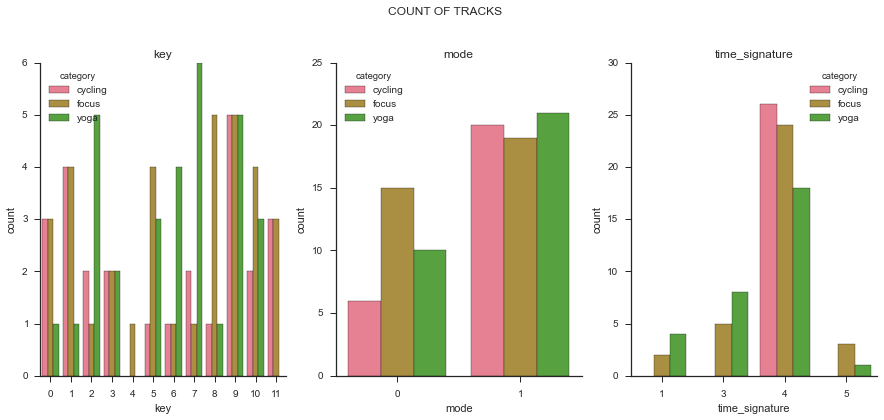

In [7]:
# set the style
sns.set_style("ticks") 

# create 3 subplots
fig0, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                      sharey=False,
                                      figsize=(15,6))

# space between the title and the plot
plt.subplots_adjust(top=0.85) 
# add a title
fig0.suptitle('COUNT OF TRACKS')

# remove the top and right spines from plots
sns.despine()

def count_plot_attr():
    """Create count plot for 3 attributes.
    """
    attr = [('key', ax0), 
            ('mode', ax1),
            ('time_signature', ax2)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)
        
        # create a count plot
        sns.countplot(x=item, hue="category", 
                      data=train_df,
                      ax=ax)
        
count_plot_attr()

Next I compare the three classes by their track attributes. I group the data by categories and then calculate mean value and standard deviation for each class in every attribute. 

In [8]:
# group by category
grouped = train_df.groupby(['category'])

# mean value in every attribute
print "Mean values"
train_mean = grouped.mean()
train_mean

Mean values


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
category,,,,,,,,,,,
cycling,0.11,0.60,0.79,0.08,5.58,-5.97,0.77,0.06,136.66,4.00,0.70
focus,0.56,0.33,0.33,0.88,6.09,-19.40,0.56,0.05,113.51,3.76,0.21
yoga,0.84,0.44,0.19,0.81,5.84,-19.55,0.68,0.04,110.50,3.39,0.23


Mean values reveal the differences between the three groups in their attributes. 
TODO: write a summary.

In [9]:
print "Standard deviation"
grouped.std()

Standard deviation


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
category,,,,,,,,,,,
cycling,0.22,0.14,0.14,0.19,4.06,2.51,0.43,0.03,22.40,0.00,0.21
focus,0.37,0.23,0.23,0.16,3.71,6.69,0.50,0.03,38.17,0.85,0.20
yoga,0.22,0.19,0.14,0.25,2.97,5.85,0.48,0.01,27.25,1.05,0.21


Standard devation is a measure of how spread out numbers are. The "cycling" class has the least spread out numbers, where the "focus" class is rather inconsistent.  

I make a violinplot to visualize the data. Violin plot combines a boxplot with the kernel density estimation procedure to provide a better description of the distribution of values. Additionally, the quartile values from the boxplot are shown inside the violin by adding inner="quartile" parameter. Mean values are marked with a white cross. 

I also use the function swarmplot() that positions each scatterplot point on the categorical axis with an algorithm that avoids overlapping points. This gives a better representation of the distribution of values.

Here I plot features "acousticness", "danceability", "energy", "instrumentalness", and "valence". These features  spread out from 0 to 1. Note that due to the shape of the plot the figure might go below 0 and above 1. Seaborn allows to limit the violin range within the range of the observed data (cut=0), but here I leave them as is.  

"Speechiness" is on the same level in three classes, it's not interesting to plot it. 

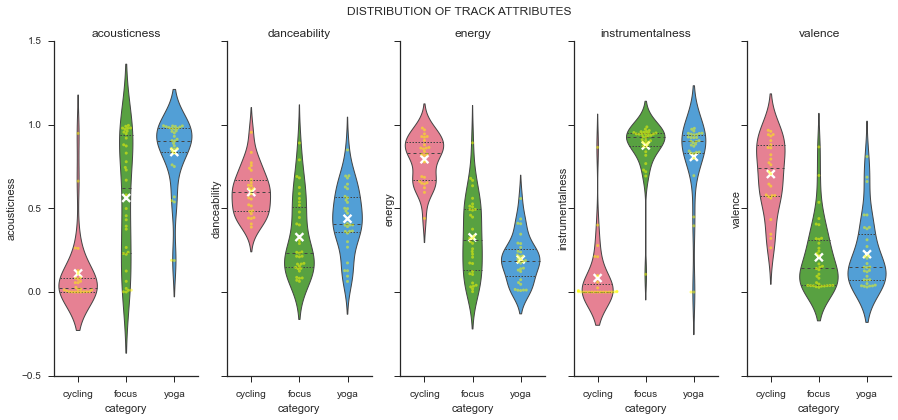

In [10]:
# create 5 subplots
fig1, (ax3, ax4, 
      ax5, ax6, 
      ax7) = plt.subplots(nrows=1, ncols=5,
                          sharey=True, # leave y ticks only on the first column of plots
                          figsize=(15,6))

# add a title
fig1.suptitle('DISTRIBUTION OF TRACK ATTRIBUTES')

# remove the top and right spines from plots
sns.despine()

def violin_plot_attr():
    """Create violin plot and swarmplot for
    5 attributes.
    """
    attr = [('acousticness', ax3), 
            ('danceability', ax4),
            ('energy', ax5), 
            ('instrumentalness', ax6), 
            ('valence', ax7)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)
        
        # create a violin plot
        sns.violinplot(x="category", y=item, 
                       data=train_df, inner="quartile", # draw the quartiles of the distribution
                       linewidth=1, palette="husl",
                       ax=ax)
        
        # add marker for mean values
        sns.pointplot(x="category", y=item,
                      data=train_df, 
                      markers="x", ci=None, # remove confidence intervals 
                      join=False, 
                      color="white", alpha=.5, 
                      ax=ax)
        
        # create a swarmplot on top of the violin plot
        sns.swarmplot(x="category", y=item, 
                      data=train_df, 
                      alpha=.5, size=3, # alpha adds saturation
                      color="yellow", edgecolor="gray", 
                      ax=ax)
        

violin_plot_attr()

TODO: summary

To plot "loudness" and "tempo" I use box plot, which is the foundation of the violin plot. A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

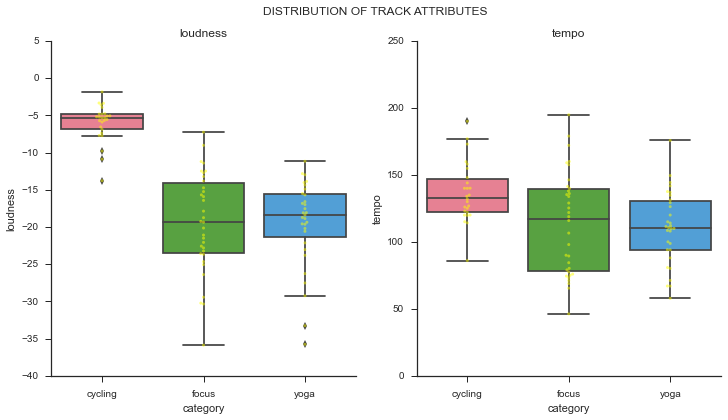

In [11]:
# create 2 subplots
fig2, (ax8, ax9) = plt.subplots(nrows=1, ncols=2,
                              sharey=False,
                              figsize=(12,6))

fig2.suptitle('DISTRIBUTION OF TRACK ATTRIBUTES')

# remove the top and right spines from plots
sns.despine()

def box_plot_attr():
    """Create box plot and swarmplot for
    2 attributes.
    """
    attr = [('loudness', ax8), 
            ('tempo', ax9)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)

        # create a box plot
        sns.boxplot(x="category", y=item,
                   data=train_df,
                   palette="husl", 
                    ax=ax)
        
        # create a swarmplot on top of the violin plot
        sns.swarmplot(x="category", y=item, 
                      data=train_df, 
                      alpha=.5, size=3,
                      color="yellow", edgecolor="gray", 
                      ax=ax)
        
        
box_plot_attr()

In [ ]:
# TODO: write a summary

### Test data overview

Now I move on to exploration of the test dataset.

In [257]:
# create a df with test data
test_df = read_db_in_pandas(test_db)

# rearrange the order of columns 
test_cols = test_df.columns.tolist()
test_cols = test_cols[0:1] + test_cols[2:3] + test_cols[1:2] + test_cols[3:]
test_df = test_df.ix[:, test_cols]

print ("There are {0} tracks in the dataset."
       .format(len(test_db)))
print ("{0} tracks have no data available " 
       "in the Echo Nest API."
       .format(len(test_db) - len(test_df)))
print ("We are left with {0} tracks to use as a test set."
       .format(len(test_df)))
print "\nSummary statistics: "
test_df.describe()

There are 554 tracks in the dataset.
223 tracks have no data available in the Echo Nest API.
We are left with 331 tracks to use as a test set.

Summary statistics: 


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
count,331.00,331.00,331.00,331.00,331.00,331.00,331.00,330.00,331.00,331.00,331.00
mean,0.27,0.61,0.64,0.26,5.13,-9.00,0.56,0.07,118.47,3.96,0.52
std,0.29,0.16,0.21,0.34,3.66,4.20,0.50,0.07,24.94,0.29,0.25
min,0.00,0.14,0.02,0.00,0.00,-29.23,0.00,0.02,52.61,1.00,0.03
25%,0.02,0.52,0.49,0.00,2.00,-10.71,0.00,0.03,101.02,4.00,0.32
50%,0.15,0.63,0.68,0.04,5.00,-8.20,1.00,0.04,119.90,4.00,0.53
75%,0.46,0.71,0.80,0.58,8.00,-6.19,1.00,0.06,131.62,4.00,0.72
max,0.99,0.95,1.00,0.95,11.00,-1.65,1.00,0.69,201.51,5.00,0.97


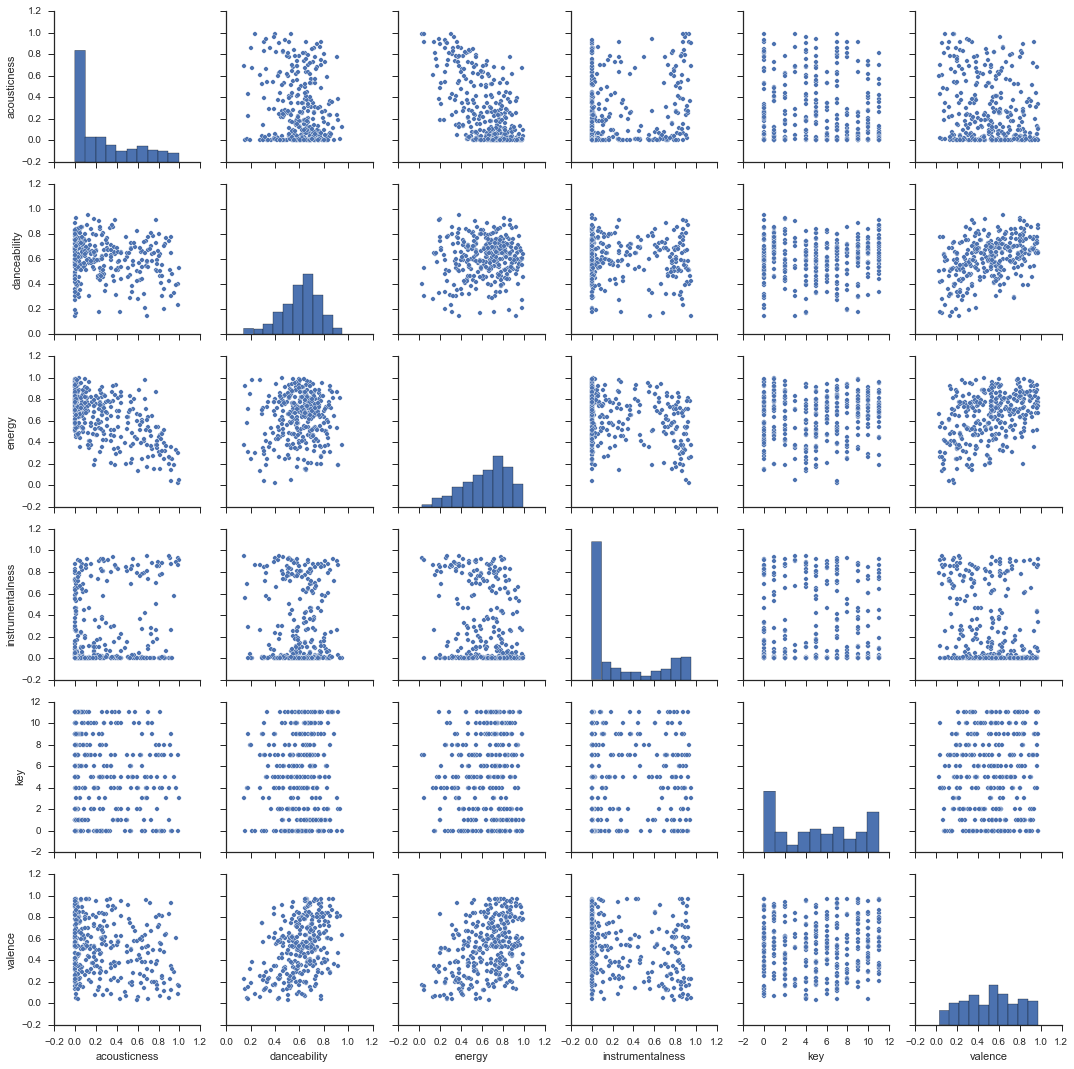

In [266]:
sns.despine(top=False, right=True)
sns.pairplot(test_df, 
             vars=['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'valence'], palette="husl")